# **Lab 1 : First order methods on regression models**

#### **Authors:** A. Gramfort, R. Gower, P. Ablin, M. Massias

## **Aim**

The aim of this material is to code 
- proximal gradient descent (PGD)
- accelerated gradient descent (APGD) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- L2 penalization
- L1 penalization

----
## **VERY IMPORTANT**

- This work **must be done by pairs of students**.
- **Each** student must send their work using the **moodle platform**. Please check the deadline on moodle!
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

## **Gentle reminder:** no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "bryan"
ln1 = "chen"
fn2 = "alice"
ln2 = "devilder"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_chen_bryan_and_devilder_alice.ipynb


----

In [2]:
## to embed figures in the notebook
%matplotlib inline

-----

## **Part 0 : Introduction**

We'll start by generating sparse vectors and simulating data

### **Getting sparse coefficients**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy
# np.random.seed(42)

Text(0.5, 1.0, 'Parameters / Coefficients')

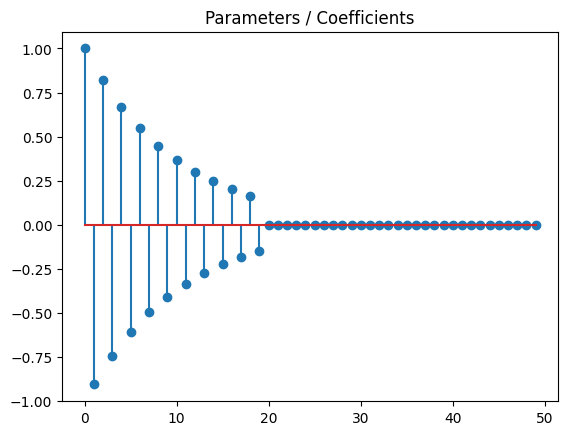

In [4]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### **Functions for the simulation of the models**

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg import toeplitz


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
         Correlation between features i and j is corr^|i - j|


    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + np.random.randn(n_samples)
    return A, b


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation between features i and j is corr^|i - j|

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## **Generate the data**

In [6]:
A, b = simu_linreg(coefs)
# A, b = simu_logreg(coefs)  # uncomment when you want to test logistic regression

----

## **Part 1 : Proximal operators**

We remind that the proximal operator of a function $R$ is given by:

$$
\text{prox}_{(\lambda \,R)}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \,R(z) \right\}.
$$


We have in mind to use the following cases

- L2 penalization, where $R(z) = \frac{1}{2} \|z\|_2^2$
- L1 penalization, where $R(z) =  \|z|\|_1$

where $\lambda > 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $R(x)$ in both cases and $\text{prox}_{\lambda\, R}(x)$ for L2 and  L1 penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the L2 and L1 
    </li>
    </ul>
</div>

In [7]:
def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x""" 
    return np.sign(x) * np.maximum(np.abs(x) - lmbd, 0)
    
def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    return lmbd * np.linalg.norm(x, ord=1)

def prox_L2(x, lmbd):
    """Proximal operator for the L2 at x"""    
    return x / (1 + lmbd)
    
def L2_norm(x, lmbd):
    """Value of the L2 penalization at x"""
    return lmbd/2 * np.linalg.norm(x, ord=2) ** 2

## **Visualization**

We are now going to visualize the effect of the proximity operators on coefficients.

(-2.0, 2.0)

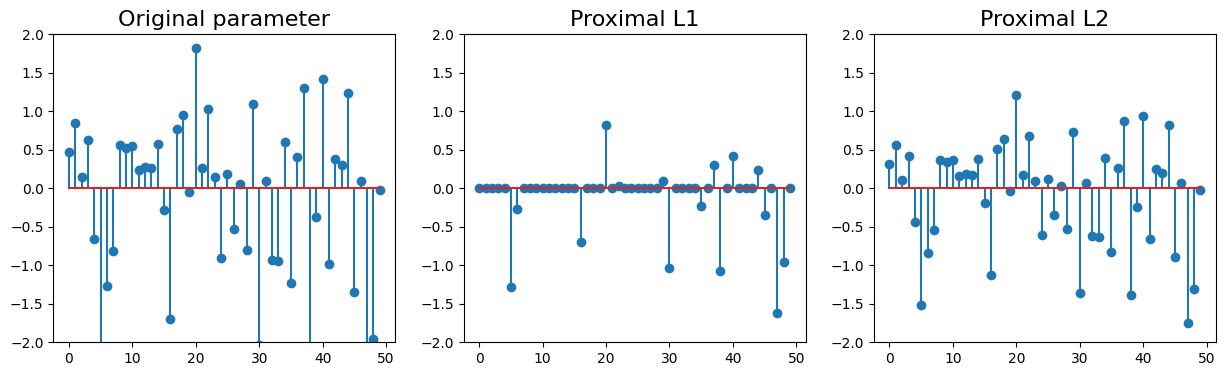

In [8]:
x = np.random.randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_L1(x, lmbd=l_l1))
plt.title("Proximal L1", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_L2(x, lmbd=l_l2))
plt.title("Proximal L2", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

**Comments:** We observe that using the proximal operator with L1 penalization, we can shrink the coefficients to zero and promote sparsity while the L2 penalization doesn't set the coefficients to zero but shrink them towards zero. 

-----

## **Part 2: Gradients**

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + \lambda \,R(x)
$$
where $f$ is $L$-smooth and $R$ has a simple proximal operator.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A = [a_1,\ldots, a_n]^{\top} \in \mathbb{R}^{n \times d}$ is the matrix of samples.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

- For the linear regression:
$$\nabla f (x) = -\frac{1}{n} A^\top (b-Ax)$$

- For the logistic regression:
$$\nabla f (x) = \frac{1}{n} \sum_{i=1}^{n} \frac{-b_ia_i^\top \exp(-b_i a_i^\top x)}{1 + \exp(-b_i a_i^\top x)} = -\frac{1}{n} \sum_{i=1}^n b_ia_i^\top \sigma(-b_ia_i^\top x)$$ 

where $\sigma$ is the sigmoid function, in other words $\sigma(t) = \frac{1}{1 + \exp(-t)}$.

In [9]:
def loss_linreg(x):
    """Least-squares loss"""
    n_samples = A.shape[0]
    return np.linalg.norm(b - A @ x, ord=2)**2/(2*n_samples)

def grad_linreg(x):
    """Leas-squares gradient"""
    n_samples = A.shape[0]
    return A.T @ (A@x - b)/n_samples

def loss_logreg(x):
    """Logistic loss"""
    return np.mean(np.log(1 + np.exp(-b * (A @ x))), axis=0)

def grad_logreg(x):
    """Logistic gradient"""
    return np.mean(-b[:, np.newaxis] * A *  sigmoid(-b * (A @ x))[:, np.newaxis], axis=0)

In [10]:
## CHECK
import scipy

A_lin, b_lin = simu_linreg(coefs)
print(scipy.optimize.check_grad(loss_linreg, grad_linreg, x))
A_log, b_log = simu_logreg(coefs)
print(scipy.optimize.check_grad(loss_logreg, grad_logreg, x))


2.673738250716006e-06
3.64573351058409e-07


**Comments:** Our functions implemented for the gradients are correct since the difference between the numerical gradient and the analytical gradient  (check_grad) is very small of order 1e-6 for both linear regression and logistic regression.

----
## **Part 3: Solvers**

We now have a function to compute $f$, $\nabla f$ and $R$ and $\text{prox}_R$. 

We want now to code the PGD and APGD solvers to minimize

$$
\arg\min_x f(x) + \lambda \, R(x)
$$

where $\lambda >0$ is the regularization parameter

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `PGD` and `APGD` below that implements the 
  PGD(Proximal Gradient Descent) and APGD (Accelerated Proximal 
  Gradient Descent) algorithms</li>
    </ul>
</div>

**Answers:** To find the Lipschitz constants for linear and logistic regression losses, we will compute the maximum eigenvalue of the Hessian of the corresponding loss.
$$ \lambda_{max} (\nabla_x^2 F(x)) \leq L$$


- **For the linear regression:** The gradient of the loss function for linear regression is given by: $\nabla F (x) = -\frac{1}{n} A^\top (b-Ax)$

The Hessian is therefore: 
$$\nabla_x^2 F(x) = \frac{A^\top A}{n}$$

- **For the logistic regression:** The gradient of the loss function for logistic regression is given by: $\nabla F (x) = -\frac{1}{n} \sum_{i=1}^n b_ia_i^\top \sigma(-b_ia_i^\top x)$

We know that the derivative of the sigmoid is:
$$\frac{d}{dx} \sigma(x) = \sigma(x)(1-\sigma(x))$$

Thus, the derivative of sigmoid applied to $b_i a_i^\top x$ is:

$$\frac{d}{dx} \sigma(-b_i a_i^\top x) = - b_i a_i^\top  \ \sigma(-b_i a_i^\top x) (1 - \sigma(-b_i a_i^\top x)) $$


The Hessian is therefore:
$$\nabla_x^2 F(x) =\frac{1}{n} \sum_{i=1}^n (b_i a_i^\top)(b_i a_i^\top) \sigma(-b_i a_i^\top x) (1 - \sigma(-b_i a_i^\top x))  = \frac{1}{n} \sum_{i=1}^n (b_i a_i^\top)^2 (1 - \sigma(b_i a_i^\top x)) \sigma(b_i a_i^\top x)$$

The properties of the sigmoid function are such that $\sigma(-x) = 1 - \sigma(x)$. Moreover, $b_i$ is either $1$ or $-1$, so $b_i^2 = 1$. Therefore we can simplify the expression to:

$$\nabla_x^2 F(x) = \frac{1}{n} \sum_{i=1}^n a_i a_i^\top (1 - \sigma(b_i a_i^\top x)) \sigma(b_i a_i^\top x) $$
$$$$

In [11]:
# Calculate the smoothness constant for L2 + L2 regularizor
def smoothness_const_linreg(A):
    """Lipschitz constant for linear squares loss"""
    n = A.shape[0]
    H = A.T @ A /n
    return np.linalg.norm(H, ord=2)

# Calculate the smoothness constant for Logistic loss + L2 regularizor    
def smoothness_const_logreg(A):
    """Lipschitz constant for logistic loss"""  
    n, d = A.shape
    hessian_sum = np.zeros((d, d))
    
    for i in range(n):
        a_i = A[i].reshape(-1, 1) 
        b_i = b[i]
        
        a_i_dot_x = a_i.T @ x
        sigmoid_term = sigmoid(b_i * a_i_dot_x)
        hessian_sum += (a_i @ a_i.T) * (1 - sigmoid_term) * sigmoid_term
    
    H = hessian_sum / n
    return np.linalg.norm(H, ord=2)
    
def PGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # n_samples and n_features are not used (they could be parameters for the grad_f function) in the function because they are global variables
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    if verbose:
        print("Lauching PGDsolver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        
        x_new = x - step * grad_f(x)
        x = prox_R(x_new, lmbd*step)

        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [12]:
def APGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for APGD
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching APGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        x_new = prox_R(z - step*grad_f(z), lmbd*step)
        t_new = (1 + np.sqrt(1 + 4 * t**2))/2
        z = x_new + ((t - 1)/t_new) * (x_new - x)

        x = x_new 
        t = t_new 

        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## **Algorithms comparison and numerical experiments**

In [13]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 1000
lmbd = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with L2 
  penalization problem using the parameters give above. This can be done by using APGD with 
  1000 iterations.</li>
    <li>Compare the convergences of PGD and APGD, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

### 1.1. Minimum and minimizer of the **linear regression with L2 penalization** with APGD and PGD:

In [14]:
A, b = simu_linreg(coefs)
L_lin = smoothness_const_linreg(A)
print("The step is 1/L=",1/L_lin)
APGD_x_L2_lin, APGD_obj_L2_lin, APGD_error_L2_lin = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_R=prox_L2, step=1/L_lin, lmbd=lmbd, n_iter=n_iter,x_true=coefs, verbose=False)
print("\nThe minimum found with APGD on Linear regression with L2 penalization problem is:", APGD_obj_L2_lin[-1])
print("The corresponding minimizer is", APGD_x_L2_lin)
print("The value of the gradient norm at the minimizer with APGD considering the regularizer is ", np.linalg.norm(grad_linreg(APGD_x_L2_lin) + lmbd*APGD_x_L2_lin))

PGD_x_L2_lin, PGD_obj_L2_lin, PGD_error_L2_lin = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_R=prox_L2, step=1/L_lin, lmbd=lmbd, n_iter=n_iter,x_true=coefs, verbose=False)
print("\nThe minimum found with PGD on Linear regression with L2 penalization problem is:", PGD_obj_L2_lin[-1])
print("The corresponding minimizer is", PGD_x_L2_lin)
print("The value of the gradient norm at the minimizer with PGD considering the regularizer is ", np.linalg.norm(grad_linreg(PGD_x_L2_lin) + lmbd*PGD_x_L2_lin))

The step is 1/L= 0.31813995960557945

The minimum found with APGD on Linear regression with L2 penalization problem is: 0.47332069422072287
The corresponding minimizer is [ 0.89 -0.81  0.8  -0.76  0.69 -0.66  0.56 -0.49  0.41 -0.34  0.32 -0.27
  0.27 -0.25  0.31 -0.25  0.22 -0.14  0.16 -0.14  0.01 -0.    0.    0.05
 -0.06  0.03 -0.02 -0.04  0.08 -0.03 -0.04 -0.03  0.01  0.04 -0.05 -0.
  0.08 -0.07  0.08 -0.04  0.02 -0.03  0.01  0.    0.02  0.04  0.01  0.
  0.05 -0.03]
The value of the gradient norm at the minimizer with APGD considering the regularizer is  7.812364298328545e-16

The minimum found with PGD on Linear regression with L2 penalization problem is: 0.47332069422072287
The corresponding minimizer is [ 0.89 -0.81  0.8  -0.76  0.69 -0.66  0.56 -0.49  0.41 -0.34  0.32 -0.27
  0.27 -0.25  0.31 -0.25  0.22 -0.14  0.16 -0.14  0.01 -0.    0.    0.05
 -0.06  0.03 -0.02 -0.04  0.08 -0.03 -0.04 -0.03  0.01  0.04 -0.05 -0.
  0.08 -0.07  0.08 -0.04  0.02 -0.03  0.01  0.    0.02  0.04  0.0

**Comments:** Considering a step size of $1/L$ for the PGD and APGD algorithms, we can see that both the APGD algorithm and the PGD algorithm converges to the same minimum. As the norm of the gradient at the minimizer is zero, it confirms that our output is indeed a minimizer. But now, let's compare the convergence of the two algorithms.

### 1.2. Minimum and minimizer of the **logistic regression with L2 penalization** with APGD and PGD:

In [15]:
A, b = simu_logreg(coefs)
L_log = smoothness_const_logreg(A)
print("The step is 1/L=",1/L_log)
APGD_x_L2_log, APGD_obj_L2_log, APGD_error_L2_log = APGD(x0, loss_logreg, grad_logreg, L2_norm, prox_R=prox_L2, step=1/L_log, lmbd=lmbd, n_iter=n_iter,x_true=coefs, verbose=False)
print("\nThe minimum found with APGD on Linear regression with L2 penalization problem is:", APGD_obj_L2_log[-1])
print("The corresponding minimizer is", APGD_x_L2_log)
print("The value of the gradient norm at the minimizer with APGD considering the regularizer is ", np.linalg.norm(grad_logreg(APGD_x_L2_log) + lmbd*APGD_x_L2_log))

PGD_x_L2_log, PGD_obj_L2_log, PGD_error_L2_log = PGD(x0, loss_logreg, grad_logreg, L2_norm, prox_R=prox_L2, step=1/L_log, lmbd=lmbd, n_iter=n_iter,x_true=coefs, verbose=False)
print("\nThe minimum found with PGD on Linear regression with L2 penalization problem is:", PGD_obj_L2_log[-1])
print("The corresponding minimizer is", PGD_x_L2_log)
print("The value of the gradient norm at the minimizer with PGD considering the regularizer is ", np.linalg.norm(grad_logreg(PGD_x_L2_log) + lmbd*PGD_x_L2_log))

The step is 1/L= 4.998163349295006

The minimum found with APGD on Linear regression with L2 penalization problem is: 0.6982877924904458
The corresponding minimizer is [ 2.   -1.64  1.48 -1.02  1.01 -0.98  0.79 -0.55  0.77 -0.28  0.6  -0.29
  0.7  -0.48  0.09 -0.19  0.66 -0.4   0.39 -0.51  0.32 -0.04 -0.41  0.23
 -0.16 -0.21 -0.05 -0.05 -0.11  0.11 -0.47  0.16 -0.03  0.13  0.1  -0.13
 -0.18 -0.16 -0.19 -0.1  -0.16 -0.15 -0.18  0.12 -0.17 -0.33 -0.12 -0.12
  0.08 -0.15]
The value of the gradient norm at the minimizer with APGD considering the regularizer is  0.27812976877178464

The minimum found with PGD on Linear regression with L2 penalization problem is: 0.7913713630103854
The corresponding minimizer is [ 1.47 -1.13  1.13 -0.74  0.8  -0.66  0.67 -0.33  0.65 -0.14  0.47 -0.2
  0.51 -0.38  0.09 -0.17  0.44 -0.32  0.25 -0.37  0.2  -0.09 -0.37  0.05
 -0.22 -0.24 -0.15 -0.14 -0.17 -0.02 -0.42  0.04 -0.08  0.04  0.   -0.16
 -0.2  -0.19 -0.22 -0.15 -0.29 -0.2  -0.3  -0.08 -0.27 -0.36 -0.17

**Comments:** We can see that the smoothness constant of the logistic regression loss function is really small as the step size which is $1/L$ is really large (~7). Therefore, the APGD and the PGD algorithm converge to a minimum but not the minimizer. The norm of the gradient at the minimizer is not zero, which confirms that the output is not a minimizer.

### 2.1. Comparison of the convergences of PGD and APGD for the **linear regression with L2 penalization**:

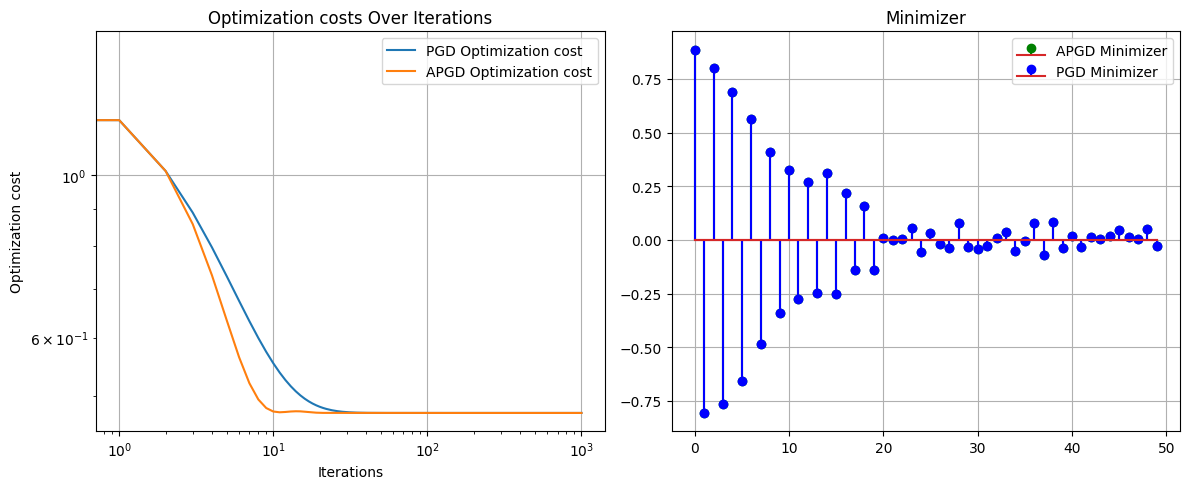

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot the Optimization costs over iterations
ax[0].semilogx(PGD_obj_L2_lin, label='PGD Optimization cost')
ax[0].semilogx(APGD_obj_L2_lin, label='APGD Optimization cost')
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Optimization cost")
ax[0].set_title("Optimization costs Over Iterations")
ax[0].grid()
ax[0].legend()
ax[0].set_yscale('log')

# Plot the minimizer
ax[1].stem(APGD_x_L2_lin, label="APGD Minimizer", markerfmt='green', linefmt='g-')
ax[1].stem(PGD_x_L2_lin, label="PGD Minimizer", markerfmt='bo', linefmt='b-')
ax[1].set_title("Minimizer")
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()

**Comments:** We observe that the APGD converges faster than the PGD but there are small oscillations due to the acceleration. This can be explained by the fact that the APGD is an accelerated method and the Optimization cost is not necessarily decreasing at each iteration. The APGD converges to the minimum in around 20 iterations and have some oscillations until 120 iterations while the PGD converges in around 40 iterations.

For the minimizer, both methods converge to the same value.

### 2.2. Comparison of the convergences of PGD and APGD for the **logistic regression with L2 penalization**:

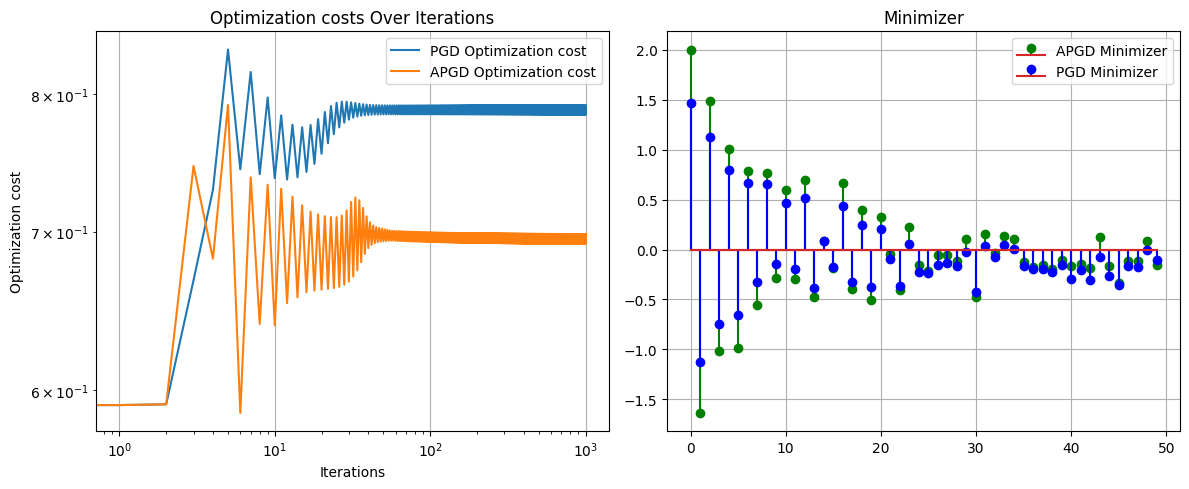

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot the Optimization costs over iterations
ax[0].semilogx(PGD_obj_L2_log, label='PGD Optimization cost')
ax[0].semilogx(APGD_obj_L2_log, label='APGD Optimization cost')
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Optimization cost")
ax[0].set_title("Optimization costs Over Iterations")
ax[0].grid()
ax[0].legend()
ax[0].set_yscale('log')

# Plot the minimizer
ax[1].stem(APGD_x_L2_log, label="APGD Minimizer", markerfmt='green', linefmt='g-')
ax[1].stem(PGD_x_L2_log, label="PGD Minimizer", markerfmt='bo', linefmt='b-')
ax[1].set_title("Minimizer")
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()

**Comments:** For the logistic regression, we observe that for both algorithm the Optimization cost doesn't converge to a minimum. It is oscillating around a value. This is due to the fact that the step size is too large.

### 3. (Bonus) Study of the step size for logistic regression:

As we have seen, the step size is too large for the logistic regression. Therefore, we will study the behavior of our algorithms PGD and APGD for a step size that is 10 times smaller.

In [18]:
A, b = simu_logreg(coefs)
L_log_bis = smoothness_const_logreg(A)*10
print("The step is 1/L=",1/L_log_bis)
APGD_x_L2_log_bis, APGD_obj_L2_log_bis, APGD_error_L2_log_bis = APGD(x0, loss_logreg, grad_logreg, L2_norm, prox_R=prox_L2, step=1/L_log_bis, lmbd=lmbd, n_iter=n_iter,x_true=coefs, verbose=False)
print("\nThe minimum found with APGD on Linear regression with L2 penalization problem is:", APGD_obj_L2_log_bis[-1])
print("The corresponding minimizer is", APGD_x_L2_log_bis)
print("The value of the gradient norm at the minimizer with APGD considering the regularizer is ", np.linalg.norm(grad_logreg(APGD_x_L2_log_bis) + lmbd*APGD_x_L2_log_bis))

PGD_x_L2_log_bis, PGD_obj_L2_log_bis, PGD_error_L2_log_bis = PGD(x0, loss_logreg, grad_logreg, L2_norm, prox_R=prox_L2, step=1/L_log_bis, lmbd=lmbd, n_iter=n_iter,x_true=coefs, verbose=False)
print("\nThe minimum found with PGD on Linear regression with L2 penalization problem is:", PGD_obj_L2_log_bis[-1])
print("The corresponding minimizer is", PGD_x_L2_log_bis)
print("The value of the gradient norm at the minimizer with PGD considering the regularizer is ", np.linalg.norm(grad_logreg(PGD_x_L2_log_bis) + lmbd*PGD_x_L2_log_bis))

The step is 1/L= 0.5441280109198815

The minimum found with APGD on Linear regression with L2 penalization problem is: 0.5399271254661203
The corresponding minimizer is [ 7.69e-01 -7.01e-01  7.27e-01 -5.19e-01  4.97e-01 -5.20e-01  4.78e-01
 -3.12e-01  3.52e-01 -3.31e-01  4.57e-01 -3.01e-01  2.83e-01 -3.29e-01
  3.83e-01 -3.92e-01  3.22e-01 -3.03e-01  3.14e-01 -1.87e-01 -1.51e-04
 -5.82e-02 -3.08e-02  8.39e-02 -6.95e-02  4.85e-02  5.07e-02  8.45e-02
  4.19e-02 -1.00e-01  4.99e-02 -1.39e-01  2.48e-01 -1.25e-01  7.63e-02
 -2.93e-02 -4.49e-02  2.18e-02 -7.71e-02  3.47e-02 -5.36e-02 -2.70e-02
 -3.99e-02  1.47e-01 -3.08e-01  1.50e-01 -4.99e-02  1.87e-02 -5.73e-02
  1.92e-02]
The value of the gradient norm at the minimizer with APGD considering the regularizer is  1.1873544261118759e-10

The minimum found with PGD on Linear regression with L2 penalization problem is: 0.5399271254661202
The corresponding minimizer is [ 7.69e-01 -7.01e-01  7.27e-01 -5.19e-01  4.97e-01 -5.20e-01  4.78e-01
 -3.12

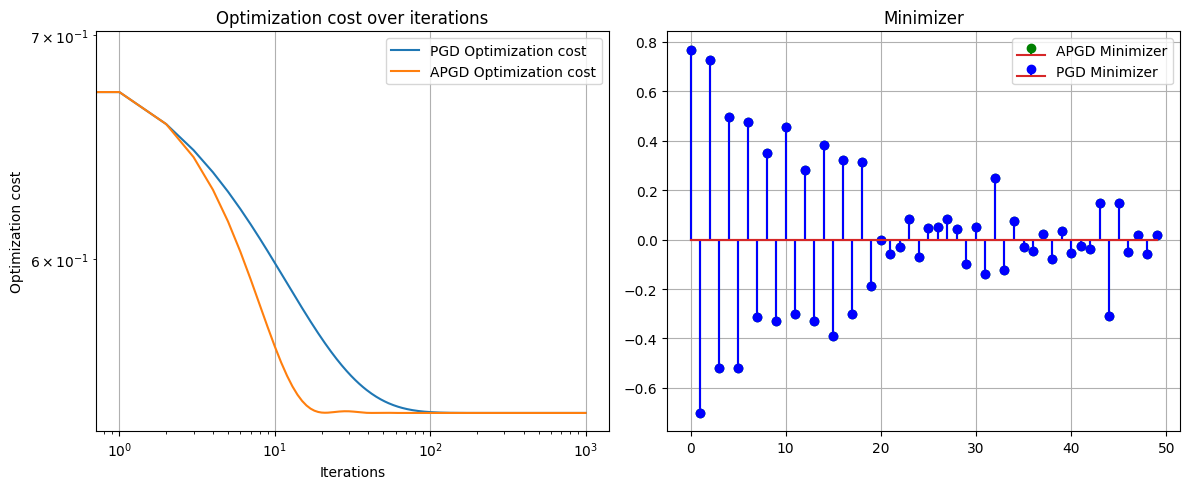

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot the objective values over iterations
ax[0].semilogx(PGD_obj_L2_log_bis, label='PGD Optimization cost')
ax[0].semilogx(APGD_obj_L2_log_bis, label='APGD Optimization cost')
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Optimization cost")
ax[0].set_title("Optimization cost over iterations")
ax[0].grid()
ax[0].legend()
ax[0].set_yscale('log')

# Plot the minimizer
ax[1].stem(APGD_x_L2_log_bis, label="APGD Minimizer", markerfmt='green', linefmt='g-')
ax[1].stem(PGD_x_L2_log_bis, label="PGD Minimizer", markerfmt='bo', linefmt='b-')
ax[1].set_title("Minimizer")
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()

**Comments:** When we divide the step size by 10, we can see that the APGD and PGD algorithms converge to the minimum and the minimizer. The APGD converges faster than the PGD. Indeed, the step of $1/L$ is considered as the worst case scenario for the step size. Therefore, it is better to have a smaller step size to ensure convergence.

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with PGD and APGD with the true parameter `coefs` of
  the model. This can be done with 3 `plt.stem` plots. Do this for one problem (linear or logistic), but for both regularizers. Comment.</li>
    <li> Pick one problem (logistic or linear) and regularizer (L1 or L2), and study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li> Pick a different problem (logistic or linear) and a different regularization (L1 or L2), and study the influence of the level of  
  penalization ($\lambda$) on the performance of the optimization algorithms. Explain. Analyse and explain the behavior of the solution vector when $\lambda$ increases.</li>
    </ul>
</div>

### 1. **Comparison of the solution we obtained with PDG and APGD with the true parameter `coefs` of the model**

### 1.1. Linear regression with L1 and L2 penalizations:

Text(0.5, 0.98, 'Stem plot with L2 penalization problem associated to linear regression')

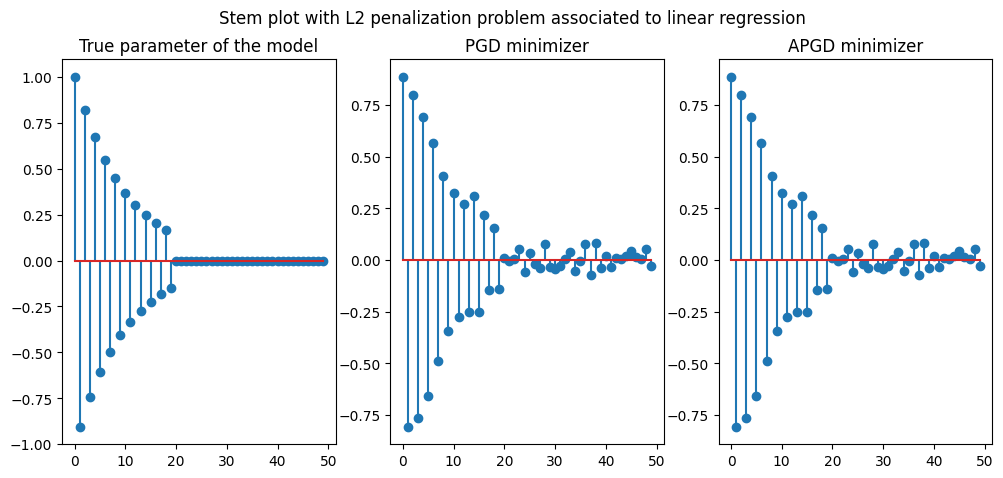

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].stem(coefs)
ax[0].set_title("True parameter of the model")
ax[1].stem(PGD_x_L2_lin)
ax[1].set_title("PGD minimizer")
ax[2].stem(APGD_x_L2_lin)
ax[2].set_title("APGD minimizer")
plt.suptitle("Stem plot with L2 penalization problem associated to linear regression")

**Comments ([LINEAR REGRESSION WITH L2 PENALIZATION] Comparison between the minimizer through each algorithm with the true parameter):** We observe that both minimizers (APGD and PGD) are not exactly equal to the true parameter. Indeed, in the true parameter from 20th features, the coefficients are set to zero while in the minimizers (APGD and PGD), the coefficients are not exactly zero since the L2 penalization actively encourages smaller coefficients values, resulting in a bias towards smaller coefficients. L2 penalization shrinks the coefficients towards zero but doesn't set them to zero. 

In [21]:
APGD_x_L1_lin, APGD_obj_L1_lin, APGD_error_L1_lin = APGD(x0, loss_linreg, grad_linreg, L1_norm, prox_R=prox_L1, step=1/L_lin, lmbd=lmbd, n_iter=n_iter,x_true=coefs, verbose=False)
PGD_x_L1_lin, PGD_obj_L1_lin, PGD_error_L1_lin = PGD(x0, loss_linreg, grad_linreg, L1_norm, prox_R=prox_L1, step=1/L_lin, lmbd=lmbd, n_iter=n_iter,x_true=coefs, verbose=False)

Text(0.5, 0.98, 'Stem plot with L1 penalization problem associated to linear regression')

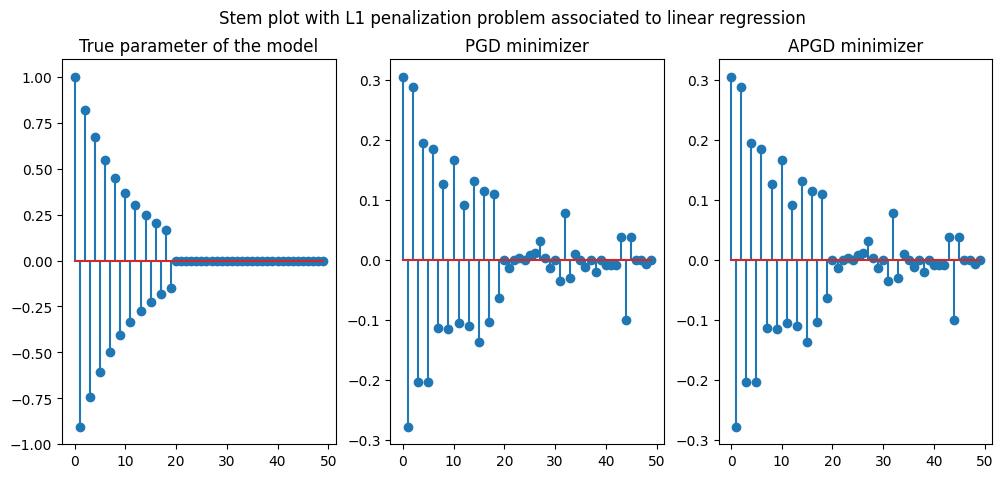

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].stem(coefs)
ax[0].set_title("True parameter of the model")
ax[1].stem(PGD_x_L1_lin)
ax[1].set_title("PGD minimizer")
ax[2].stem(APGD_x_L1_lin)
ax[2].set_title("APGD minimizer")
plt.suptitle("Stem plot with L1 penalization problem associated to linear regression")

**Comments ([LINEAR REGRESSION WITH L1 PENALIZATION] Comparison between the minimizer through each algorithm with the true parameter):** We observe that the minimizer (APGD and PGD) are still not exactly equal to the true parameter but better than the L2 penalization. Indeed, since the features of the true parameter have zero coefficients, and the L1 penalization promotes sparsity and sets the coefficients to zero, then the minimizer (APGD and PGD) are closer to the true parameter. L1 penalization is more aggressive in setting the coefficients to zero than L2 penalization.

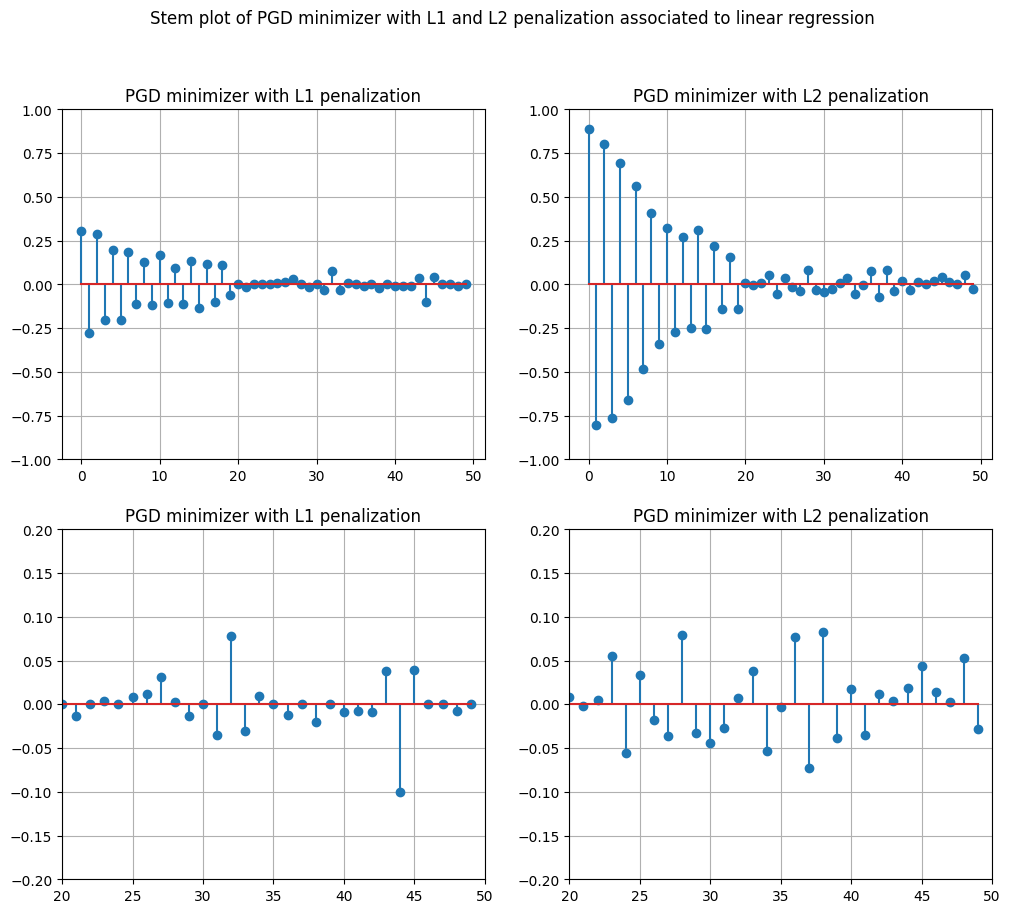

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0,0].stem(PGD_x_L1_lin)
ax[0,0].set_title("PGD minimizer with L1 penalization")
ax[0,0].set_ylim(-1,1)
ax[0,0].grid()
ax[0,1].stem(PGD_x_L2_lin)
ax[0,1].set_title("PGD minimizer with L2 penalization")
ax[0,1].set_ylim(-1,1)
ax[0,1].grid()
ax[1,0].stem(PGD_x_L1_lin)
ax[1,0].set_title("PGD minimizer with L1 penalization")
ax[1,0].set_xlim(20,50)
ax[1,0].set_ylim(-0.2,0.2)
ax[1,0].grid()
ax[1,1].stem(PGD_x_L2_lin)
ax[1,1].set_title("PGD minimizer with L2 penalization")
ax[1,1].set_xlim(20,50)
ax[1,1].set_ylim(-0.2,0.2)
ax[1,1].grid()
plt.suptitle("Stem plot of PGD minimizer with L1 and L2 penalization associated to linear regression")
plt.show()

**Comments:** We can see that the L1 penalization is more aggressive in setting the coefficients to zero than the L2 penalization. More coefficients with L1 penalization are set to zero compared to L2 penalization, which is expected, if we look from features 20.

### 1.2. Logistic regression with L1 and L2 penalizations:

Text(0.5, 0.98, 'Stem plot with L2 penalization problem associated to logistic regression')

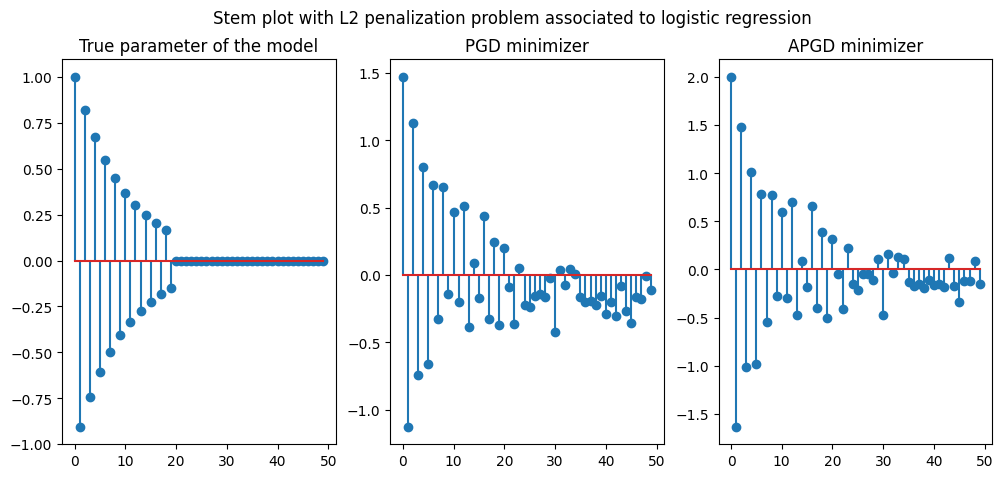

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].stem(coefs)
ax[0].set_title("True parameter of the model")
ax[1].stem(PGD_x_L2_log)
ax[1].set_title("PGD minimizer")
ax[2].stem(APGD_x_L2_log)
ax[2].set_title("APGD minimizer")
plt.suptitle("Stem plot with L2 penalization problem associated to logistic regression")

**Comments ([LOGISTIC REGRESSION WITH L2 PENALIZATION] Comparison between the minimizer through each algorithm with the true parameter):** We observe that the minimizer (APGD and PGD) are totally different from the true parameter. Indeed, the step size is too large, which makes the optimization algorithm converge to a minimum but not the minimizer.

In [25]:
APGD_x_L1_log, APGD_obj_L1_log, APGD_error_L1_log = APGD(x0, loss_logreg, grad_logreg, L1_norm, prox_R=prox_L1, step=1/L_log, lmbd=lmbd, n_iter=n_iter,x_true=coefs, verbose=False)
PGD_x_L1_log, PGD_obj_L1_log, PGD_error_L1_log = PGD(x0, loss_logreg, grad_logreg, L1_norm, prox_R=prox_L1, step=1/L_log, lmbd=lmbd, n_iter=n_iter,x_true=coefs, verbose=False)

Text(0.5, 0.98, 'Stem plot with L1 penalization problem associated to logistic regression')

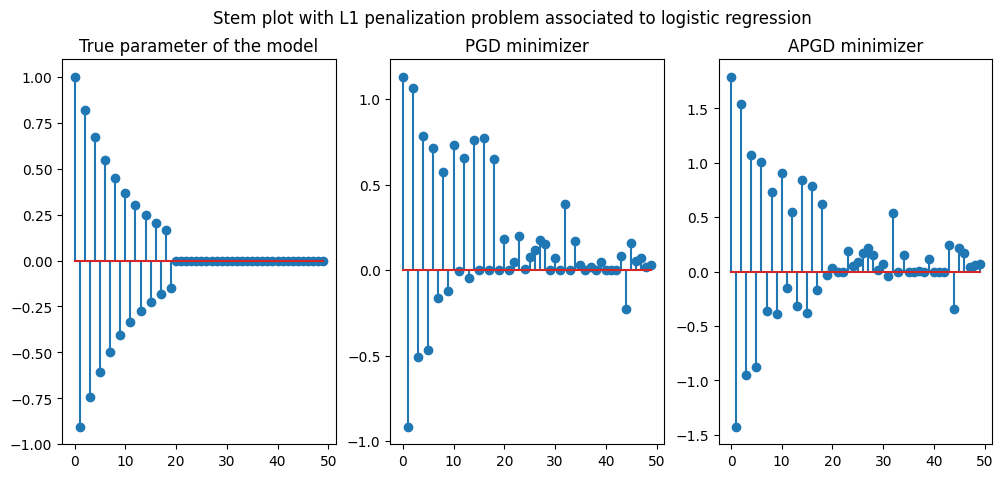

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].stem(coefs)
ax[0].set_title("True parameter of the model")
ax[1].stem(PGD_x_L1_log)
ax[1].set_title("PGD minimizer")
ax[2].stem(APGD_x_L1_log)
ax[2].set_title("APGD minimizer")
plt.suptitle("Stem plot with L1 penalization problem associated to logistic regression")

**Comments ([LOGISTIC REGRESSION WITH L1 PENALIZATION] Comparison between the minimizer through each algorithm with the true parameter):** Same remark as for the logistic regression with L2 penalization. With the APGD algorithm the minimizer seems to be closer to the true parameter than with the L1 penalization than with the L2 penalization.

#### (Bonus) With a smaller step size:

In [27]:
A, b = simu_logreg(coefs)
L_log_bis = smoothness_const_logreg(A)*10
print("The step is 1/L=",1/L_log_bis)
APGD_x_L1_log_bis, APGD_obj_L1_log_bis, APGD_error_L1_log_bis = APGD(x0, loss_logreg, grad_logreg, L1_norm, prox_R=prox_L1, step=1/L_log_bis, lmbd=lmbd, n_iter=n_iter,x_true=coefs, verbose=False)
PGD_x_L1_log_bis, PGD_obj_L1_log_bis, PGD_error_L1_log_bis = PGD(x0, loss_logreg, grad_logreg, L1_norm, prox_R=prox_L1, step=1/L_log_bis, lmbd=lmbd, n_iter=n_iter,x_true=coefs, verbose=False)

The step is 1/L= 0.5161968335765061


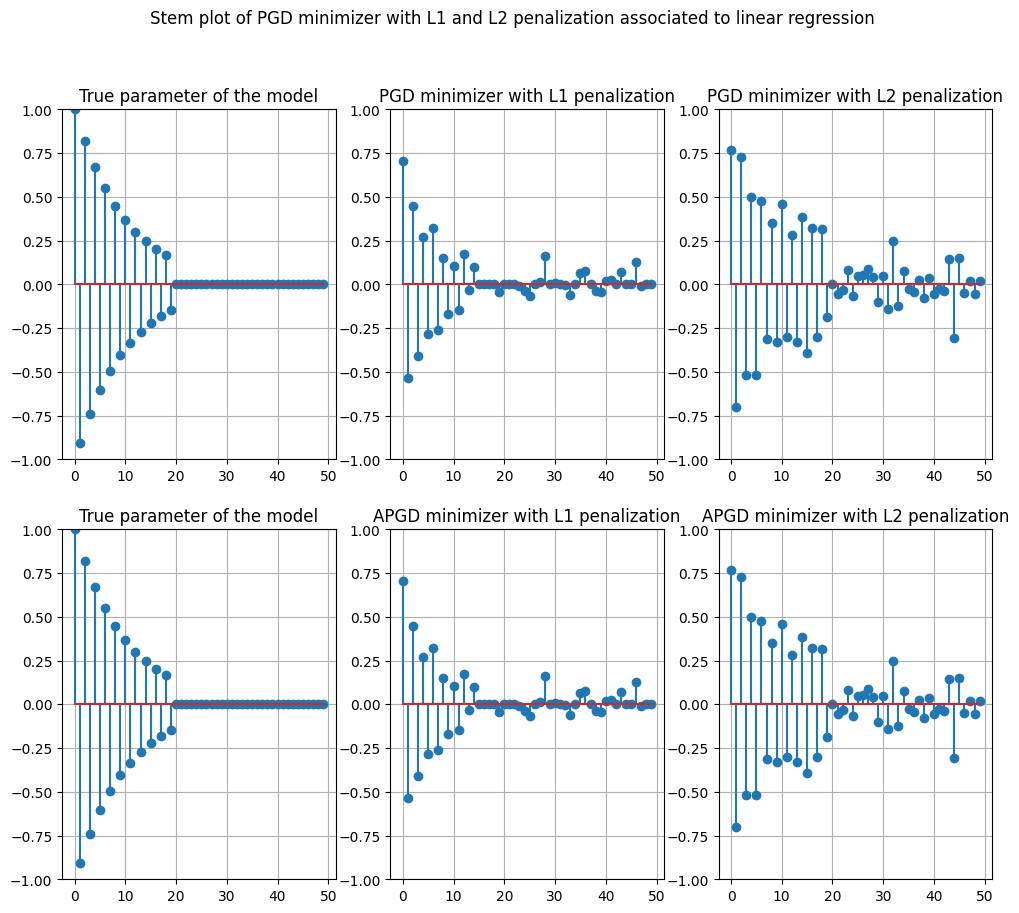

In [28]:
fig, ax = plt.subplots(2, 3, figsize=(12, 10))
ax[0,0].stem(coefs)
ax[0,0].set_title("True parameter of the model")
ax[0,0].set_ylim(-1,1)
ax[0,0].grid()

ax[0,1].stem(PGD_x_L1_log_bis)
ax[0,1].set_title("PGD minimizer with L1 penalization")
ax[0,1].set_ylim(-1,1)
ax[0,1].grid()

ax[0,2].stem(PGD_x_L2_log_bis)
ax[0,2].set_title("PGD minimizer with L2 penalization")
ax[0,2].set_ylim(-1,1)
ax[0,2].grid()

ax[1,0].stem(coefs)
ax[1,0].set_title("True parameter of the model")
ax[1,0].set_ylim(-1,1)
ax[1,0].grid()
ax[1,1].stem(APGD_x_L1_log_bis)
ax[1,1].set_title("APGD minimizer with L1 penalization")
ax[1,1].set_ylim(-1,1)
ax[1,1].grid()
ax[1,2].stem(APGD_x_L2_log_bis)
ax[1,2].set_title("APGD minimizer with L2 penalization")
ax[1,2].set_ylim(-1,1)
ax[1,2].grid()
plt.suptitle("Stem plot of PGD minimizer with L1 and L2 penalization associated to linear regression")
plt.show()

**Comments:** When we divide the step size by 10, the results are better. The minimizer is closer to the true parameter.

### 2. **Influence of the correlation of the features on the performance of the linear regression with L2 regularization**

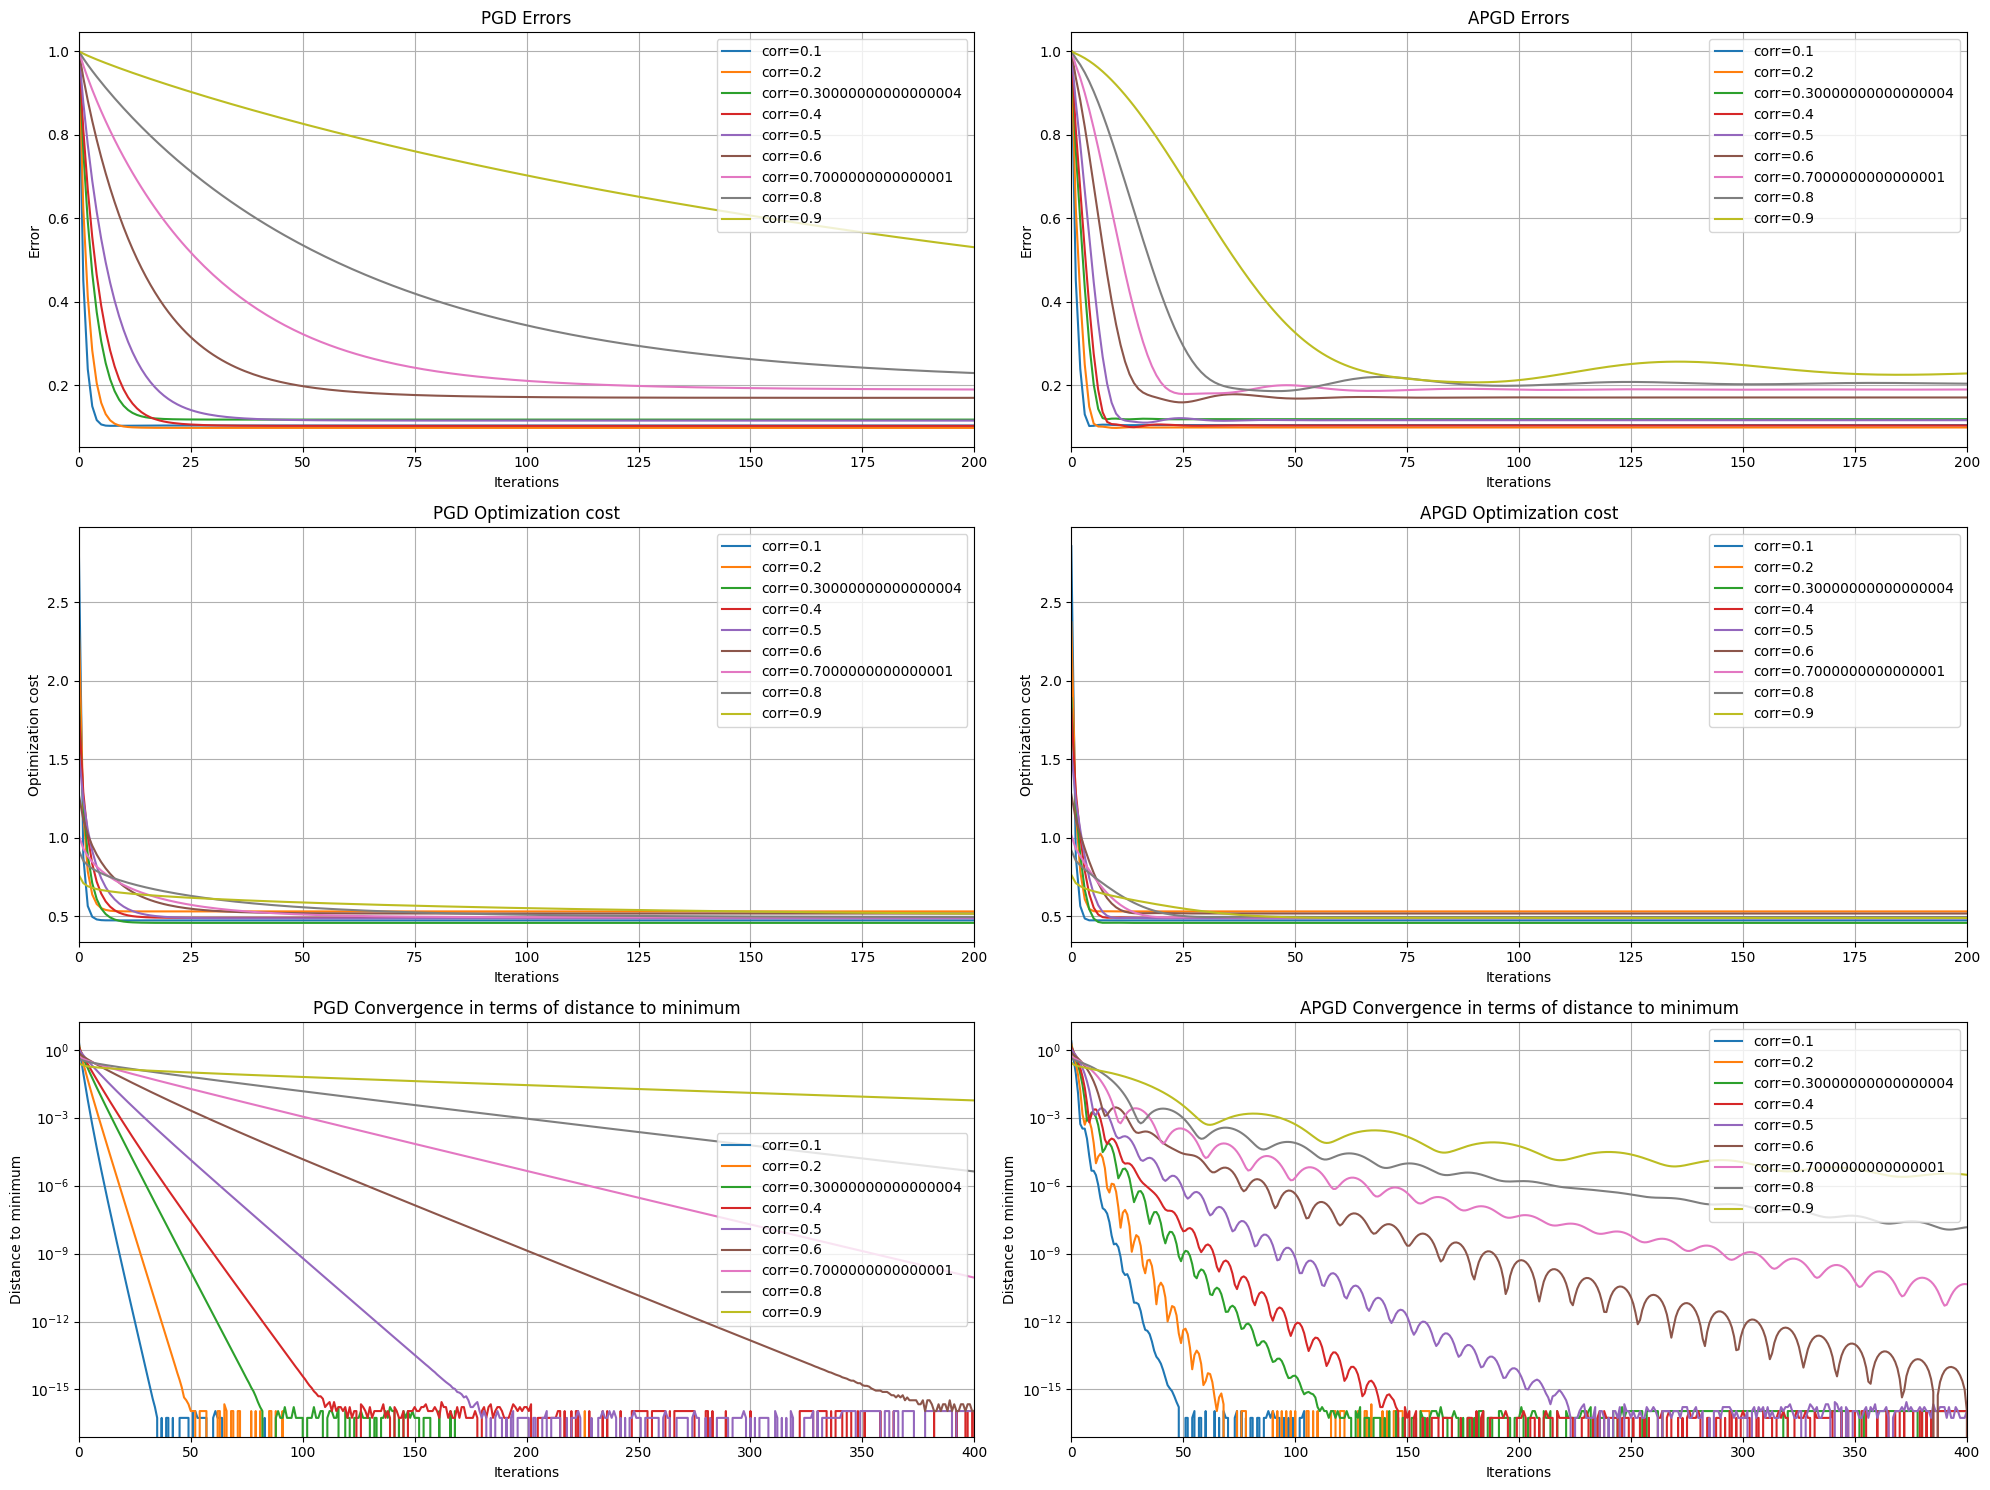

In [29]:
corr_values = np.linspace(0.1, 0.9, 9)

errors_pgd = []
errors_apgd = []
objectives_pgd = []
objectives_apgd = []

for corr in corr_values:
    A, b = simu_linreg(coefs, corr=corr)
    L = smoothness_const_linreg(A)
    
    PGD_x, PGD_obj, PGD_error = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_R=prox_L2, step=1/L, lmbd=lmbd, n_iter=n_iter, x_true=coefs, verbose=False)
    errors_pgd.append(PGD_error)
    objectives_pgd.append(PGD_obj)
    
    APGD_x, APGD_obj, APGD_error = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_R=prox_L2, step=1/L, lmbd=lmbd, n_iter=n_iter, x_true=coefs, verbose=False)
    errors_apgd.append(APGD_error)
    objectives_apgd.append(APGD_obj)

fig, ax = plt.subplots(3, 2, figsize=(20, 15))

for i, corr in enumerate(corr_values):
    ax[0, 0].plot(errors_pgd[i], label=f'corr={corr}')
    ax[0, 0].set_xlim(0,200)
    ax[0, 1].plot(errors_apgd[i], label=f'corr={corr}')
    ax[0, 1].set_xlim(0,200)
    # ax[0, 1].set_ylim(-1,1)
    ax[1, 0].plot(objectives_pgd[i], label=f'corr={corr}')
    ax[1, 0].set_xlim(0,200)
    ax[1, 1].plot(objectives_apgd[i], label=f'corr={corr}')
    ax[1, 1].set_xlim(0,200)
    # ax[1, 1].set_ylim(-1,1)
    ax[2, 0].plot(np.abs(np.array(objectives_pgd[i]) - objectives_pgd[i][-1]), label=f'corr={corr}')
    ax[2, 0].set_xlim(0,400)
    ax[2, 0].set_yscale('log')
    ax[2, 1].plot(np.abs(np.array(objectives_apgd[i]) - objectives_apgd[i][-1]), label=f'corr={corr}')
    ax[2, 1].set_xlim(0,400)
    ax[2, 1].set_yscale('log')

ax[0, 0].set_title('PGD Errors')
ax[0, 0].set_xlabel('Iterations')
ax[0, 0].set_ylabel('Error')
ax[0, 1].set_title('APGD Errors')
ax[0, 1].set_xlabel('Iterations')
ax[0, 1].set_ylabel('Error')
ax[1, 0].set_title('PGD Optimization cost')
ax[1, 0].set_xlabel('Iterations')
ax[1, 0].set_ylabel('Optimization cost')
ax[1, 1].set_title('APGD Optimization cost')
ax[1, 1].set_xlabel('Iterations')
ax[1, 1].set_ylabel('Optimization cost')
ax[2, 0].set_title('PGD Convergence in terms of distance to minimum')
ax[2, 0].set_xlabel('Iterations')
ax[2, 0].set_ylabel('Distance to minimum')
ax[2, 1].set_title('APGD Convergence in terms of distance to minimum')
ax[2, 1].set_xlabel('Iterations')
ax[2, 1].set_ylabel('Distance to minimum')

for a in ax.flat:
    a.legend()
    a.grid()

plt.tight_layout()
plt.show()

**Comments:** We observe that the higher is the correlation between the features, the slower the convergence of the algorithms. This can be explained by the fact that the Hessian of the loss function is ill-conditioned and the Lipschitz constant is higher because the matrix A will not be full rank as the features are correlated. When the correlation is low, the convergence is faster because the Hessian is well-conditioned and the Lipschitz constant is lower. For instance, when corr = 0.5, the PGD converges around iteration 200 while with corr = 0.9, the PGD converges after more than 400 iterations.

Moreover, the smaller the correlation is between the features, the faster the algorithm converges to the minimum. This is because the features are less correlated and the optimization algorithm can better identify the true parameter.

In the Convergence in terms of distance to the minimum plot with APGD, we can clearly see the oscilations due to the acceleration. The convergence is slower when the correlation is higher.

### 3. **Influence of the level of penalization ($\lambda$) on the performance of the optimization algorithms**

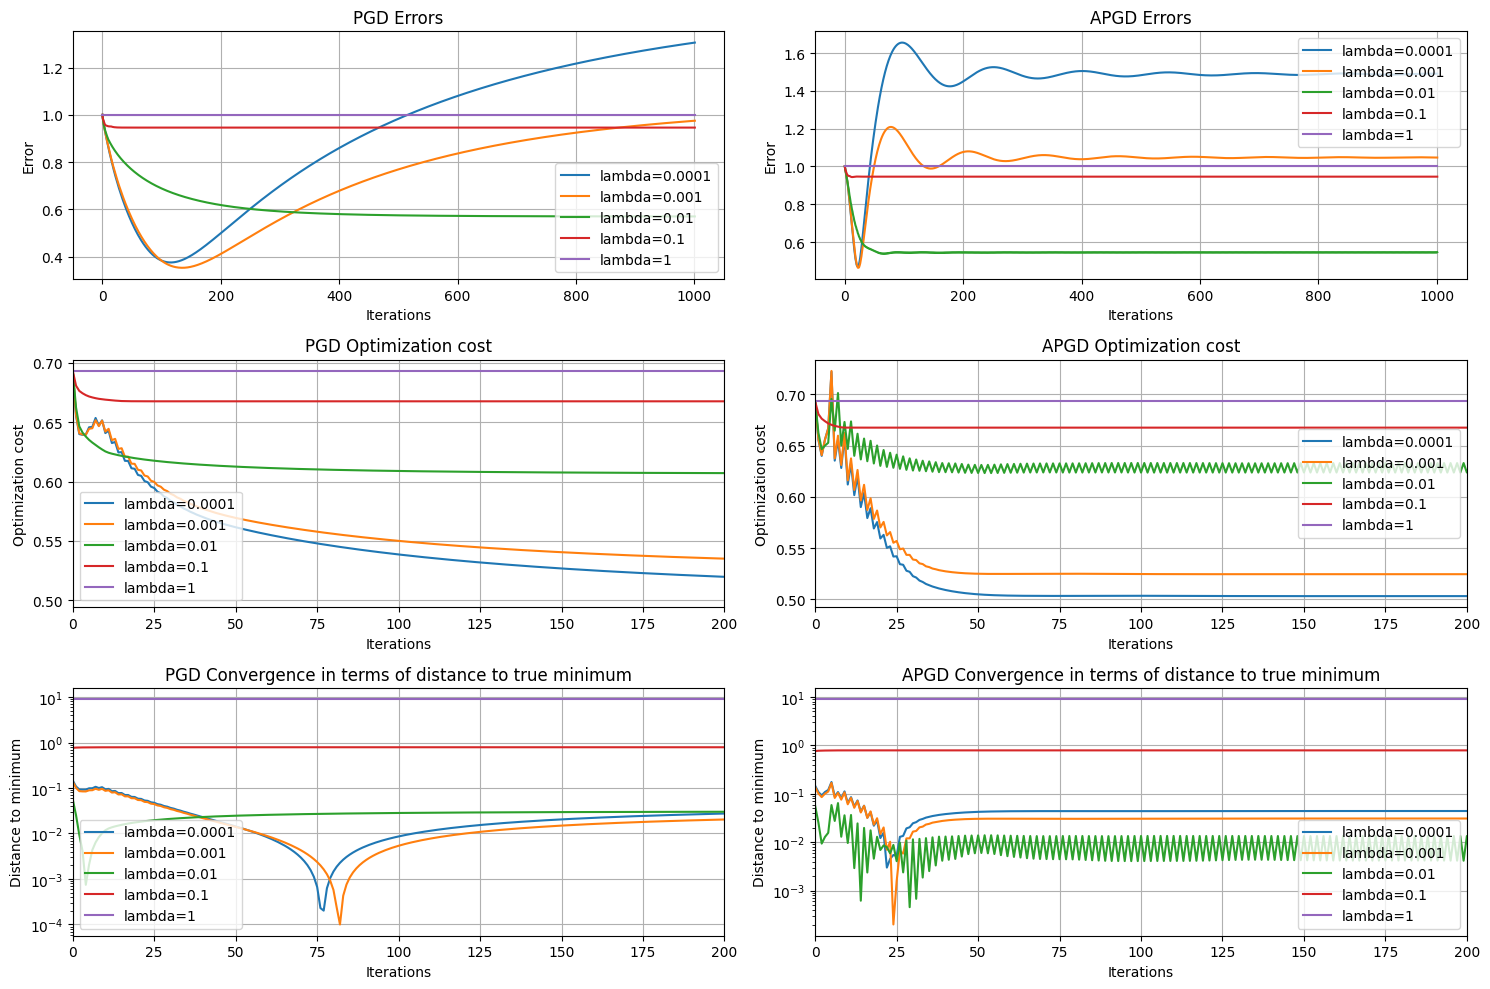

In [30]:
color_list = ['b', 'g', 'r', 'c', 'm']

lambda_values = [1e-4, 1e-3, 1e-2, 1e-1, 1]

errors_pgd = []
errors_apgd = []
objectives_pgd = []
objectives_apgd = []
solutions_pgd = []
solutions_apgd = []
objective_true = []

for lmbd in lambda_values:
    PGD_x, PGD_obj, PGD_error = PGD(x0, loss_logreg, grad_logreg, L1_norm, prox_R=prox_L1, step=1/(L_log_bis), lmbd=lmbd, n_iter=n_iter, x_true=coefs, verbose=False)
    errors_pgd.append(PGD_error)
    objectives_pgd.append(PGD_obj)
    solutions_pgd.append(PGD_x)
    
    APGD_x, APGD_obj, APGD_error = APGD(x0, loss_logreg, grad_logreg, L1_norm, prox_R=prox_L1, step=1/(L_log_bis), lmbd=lmbd, n_iter=n_iter, x_true=coefs, verbose=False)
    errors_apgd.append(APGD_error)
    objectives_apgd.append(APGD_obj)
    solutions_apgd.append(APGD_x)

    objective_true.append(loss_logreg(coefs) + L1_norm(coefs, lmbd))


fig, ax = plt.subplots(3, 2, figsize=(15, 10))

for i, lmbd in enumerate(lambda_values):
    ax[0, 0].plot(errors_pgd[i], label=f'lambda={lmbd}')
    ax[0, 1].plot(errors_apgd[i], label=f'lambda={lmbd}')
    ax[1, 0].plot(objectives_pgd[i], label=f'lambda={lmbd}')
    ax[1, 1].plot(objectives_apgd[i], label=f'lambda={lmbd}')
    ax[2, 0].plot(np.abs(np.array(objectives_pgd[i]) - objective_true[i]), label=f'lambda={lmbd}')
    ax[2, 1].plot(np.abs(np.array(objectives_apgd[i]) - objective_true[i]), label=f'lambda={lmbd}')

ax[1, 0].set_xlim(0,200)
ax[1, 1].set_xlim(0,200)
ax[2, 0].set_xlim(0,200)
ax[2, 1].set_xlim(0,200)
ax[2, 0].set_yscale('log')
ax[2, 1].set_yscale('log')

ax[0, 0].set_title('PGD Errors')
ax[0, 0].set_xlabel('Iterations')
ax[0, 0].set_ylabel('Error')
ax[0, 1].set_title('APGD Errors')
ax[0, 1].set_xlabel('Iterations')
ax[0, 1].set_ylabel('Error')
ax[1, 0].set_title('PGD Optimization cost')
ax[1, 0].set_xlabel('Iterations')
ax[1, 0].set_ylabel('Optimization cost')
ax[1, 1].set_title('APGD Optimization cost')
ax[1, 1].set_xlabel('Iterations')
ax[1, 1].set_ylabel('Optimization cost')
ax[2, 0].set_title('PGD Convergence in terms of distance to true minimum')
ax[2, 0].set_xlabel('Iterations')
ax[2, 0].set_ylabel('Distance to minimum')
ax[2, 1].set_title('APGD Convergence in terms of distance to true minimum')
ax[2, 1].set_xlabel('Iterations')
ax[2, 1].set_ylabel('Distance to minimum')

for a in ax.flat:
    a.legend()
    a.grid()

plt.tight_layout()
plt.show()

**Comments:** For both PGD and APGD, we observe that, for small $\lambda$ values (e.g., $\lambda=0.0001$ and $\lambda=0.001$), the error initially decreases but then increases, suggesting instability or overfitting when the regularization is too weak, and for larger $\lambda$ values (e.g., $\lambda=0.1$, $\lambda=1$), the error remains more stable or decreases slowly. This indicates that stronger regularization leads to more stability but might limit performance. Thus, weak regularization (small $\lambda$) leads to better initial performance but may degrade optimization over time whereas stronger regularization stabilizes the errors, though it might prevent the model from achieving lower errors. The best lambda is around 0.01, indeed the error is the smallest and the objective is the closest to the optimal value.

Let's see now the minizer compared to the true parameter for this case.

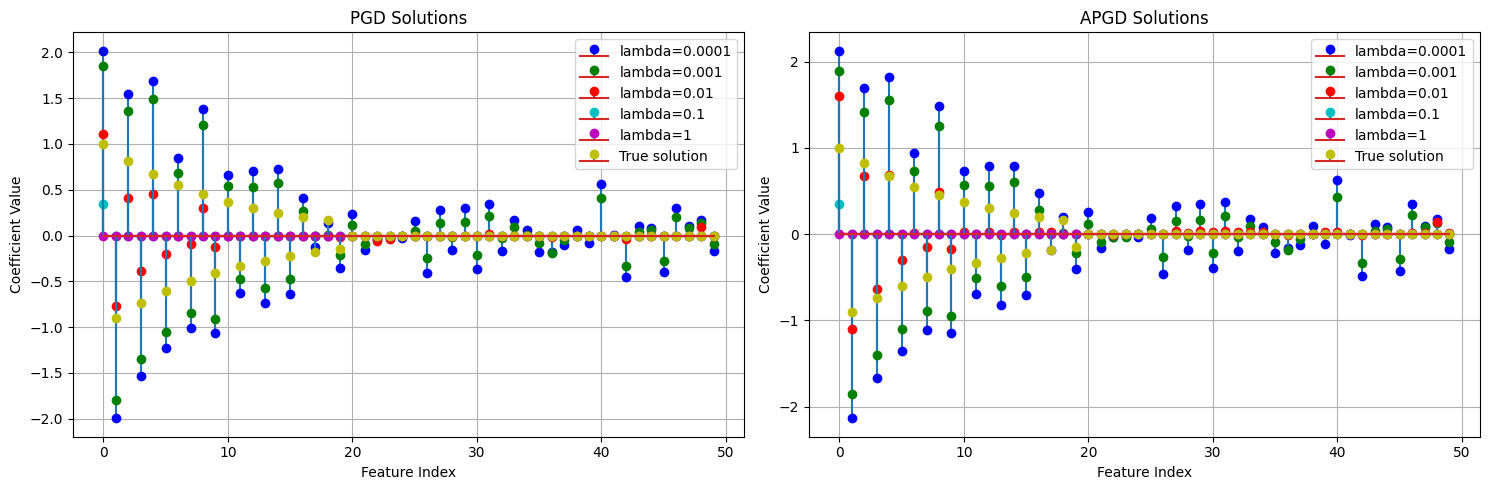

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for i, lmbd in enumerate(lambda_values):
    ax[0].stem(solutions_pgd[i], label=f'lambda={lmbd}', markerfmt=color_list[i])
    ax[1].stem(solutions_apgd[i], label=f'lambda={lmbd}', markerfmt=color_list[i])

ax[0].stem(coefs, label='True solution', markerfmt='y')
ax[1].stem(coefs, label='True solution', markerfmt='y')

ax[0].set_title('PGD Solutions')
ax[1].set_title('APGD Solutions')

for a in ax.flat:
    a.set_xlabel('Feature Index')
    a.set_ylabel('Coefficient Value')
    a.legend()
    a.grid()

plt.tight_layout()
plt.show()

**Comments:** For the stem plot, we observe that the coefficients are set to zero when lambda is close to 1, which is expected with L1 penalization because it promotes sparsity. We can observe that the true parameter (in yellow on the stem plot) is closer to the minimizer when lambda is around 0.01. However, when lambda is too small, the coefficients are too large and the error is high because the penalization is too weak (no effect). While, when lambda is too large, the coefficients are too small because the penalization is too strong.

The different $\lambda$ values demonstrate the effect of regularization, where low $\lambda$ values result in better initial performance (fast error and objective reduction) but may introduce instability and overfitting in the long run. Stronger regularization provides more stable optimization at the cost of slightly worse final performance. Moreover, APGD shows faster convergence but also more instability initially (error oscillations). In contrast, PGD converges more slowly but with fewer fluctuations.